# Optimization: strategies with decreasing information from the objective

We consider the unconstrained minimization problem $$\min_{x\in \mathbb{R}^n} f(x),$$ with $f\in C^2$.  From Prof. Stadler's notes we saw the main outline of the descent algorithm:

1. Have an initial guess $x_k$ of a minimizer.

2. Compute the gradient $g_k = \nabla f(x_k)\in L(\mathbb{R}^n,\mathbb{R})\sim \mathbb{R}^n.$ 

[We call $L(V,\mathbb{R})$ the *algebraic dual space* of $V$, $V^*$.

Like all linear operators, if its operator norm is finite, $g(x) \in B(V,\mathbb{R})$, which we call the *continuous dual space* $V'$.

We already know that if $V$ is finite dimensional, then $B(V,\mathbb{R}) = L(V,\mathbb{R})$.

We also know that for $V = \mathbb{R}^n$, a space of column vectors, that turning a vector on its side, making a row vector, makes something that, when operating on a column vector returns a number. That is $x^T y$ is a number.

In fact, *any* linear functional from $\mathbb{R}^n$ into $\mathbb{R}$ is represent by a row vector.  Thus $(\mathbb{R}^n)' \sim \mathbb{R}^n$.  This generalizes to one particular version of infinite dimensional normed vector space: the [Hilbert Space](https://en.wikipedia.org/wiki/Hilbert_space).  A Hilbert space is an inner product space that is complete, and has the following property:

Let $V$ be a hilbert space, and let $f$ be a functional in $V'$.  Then there exists a unique $x_g\in V$ such that

$$ g[y] = (x,y)_H\quad\forall y \in V,$$

and therefore $V' \sim V$.

This is known as the [Riesz representation theorem](https://en.wikipedia.org/wiki/Riesz_representation_theorem),
and $x_f$ is the Riesz representer of $f$.  In $\mathbb{R}^n$, $x$ is the Riesz representer of $x^T$.

Suppose we define the inner product of a finite dimensional space $H$ by $(x,y)_V := x^T M y$, where $M$ is symmetric positive definite.  $g[y]:y\mapsto z^T y$ is a valid functional.  What is its Riesz representer in $V$?
It isn't $z$, because $(z,y)_V = z^T M y \neq f(y)$.  Instead it is $\tilde{z} = M^{-1} z$:

$$ (\tilde{z},y)_H = z^T M^{-1} M y = g[y].$$

Why am I going into this detail?  In some applications, we may have a closed form expression for the gradient, but if we're not careful about whether we have derived $g$ or its Riesz representer, we can compute the wrong descent direction.]

3. Compute a search direction $d \in V$ such that $(-g_k)^T d >= 0$.  We do this by solving $$B_k d = -g_k,$$
for some s.p.d. matrix $B_k.$  Near the true solution, we will get fast convergence if we use the *Hessian* for $B_k$:

$$H_k = \nabla^2 f(x_k) \in L(\mathbb{R}^n,\mathbb{R}^n) \sim \mathbb{R}^{n \times n}.$$

[When working in a Hilbert space, by definition $H_k \in L(V, V^*)$, or if all quantities are bounded and continuous, $H_k \in B(V, V')$.]

4. Compute an update $x_{k + 1} = x_k + \alpha d$, where the *step length* alpha is chosen to guarantee sufficient decrease in the objective by a line search procedure.

## Example

In [1]:
from scipy.optimize import minimize
from numpy.random import randn
from numpy import log2
from fenics import *
from scipy.linalg import inv, norm

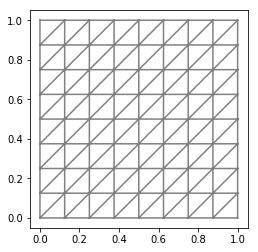

In [2]:
%matplotlib inline
n_mesh = 8
alpha = 1.
beta = 1. / (n_mesh * n_mesh)

mesh = UnitSquareMesh(n_mesh,n_mesh)
plot(mesh)

In [3]:
M = FunctionSpace(mesh,'DG',0)
V = FunctionSpace(mesh,'CG',1)
D = FunctionSpace(mesh,'DG',1)

m_dim = M.dim()
v_dim = V.dim()
d_dim = D.dim()
print((m_dim,v_dim,d_dim))

(128, 81, 384)


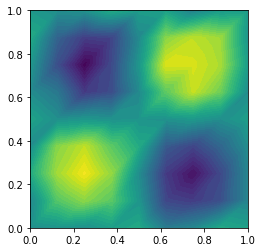

In [4]:
from numpy.random import randn

d_exp = Expression('0.1 * sin(2 * pi * x[0]) * sin(2 * pi * x[1])', degree = 1)
d = interpolate(d_exp,D)
d.vector()[:] += 0.01 * randn(d_dim)
plot(d)

In [5]:
def b(u):
    return assemble(0.5 * (u - d) * (u - d) * dx)

b(Constant('1'))

0.5005959190099236

In [6]:
b(d)

0.0

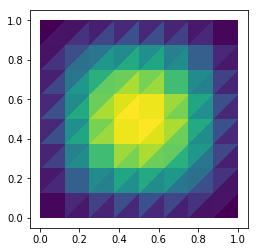

In [7]:
m_0 = interpolate(Expression('sin(pi * x[0]) * sin(pi * x[1])', degree = 1),M)
m_0_array = m_0.vector()[:]
plot(m_0)

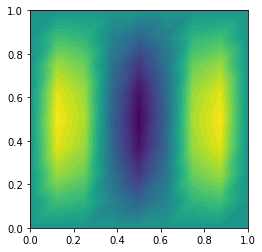

In [8]:
rhs_exp = Expression('sin(3 * pi * x[0]) * sin(pi * x[1])',degree = 1)
rhs = interpolate(rhs_exp,V)

plot(rhs)

In [9]:
def u(m):
    v = TestFunction(V)
    u_sol = Function(V)
    A = (inner(grad(v),exp(m) * grad(u_sol)) + beta * u_sol * v - v * rhs)* dx
    solve(A == 0, u_sol)
    return u_sol

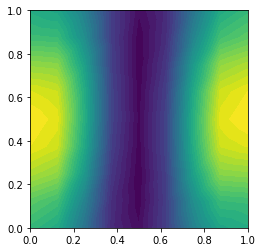

In [10]:
u_0 = u(m_0)
plot(u_0)

In [11]:
def reg(m):
    return assemble(alpha * 0.5 * (m * m) * dx)

reg(m_0)

0.12499999999999994

In [12]:
def misfit(m):
    return b(u(m))

misfit(m_0)

28.302484373650362

In [13]:
def f(m_array):
    m = Function(M)
    m.vector().set_local(m_array)
    return misfit(m) + reg(m)

f(m_0_array)

28.427484373650362

In [14]:
def reg_m(m):
    m_hat = TrialFunction(M)
    grad = assemble(alpha * (m * m_hat) * dx)
    return grad

reg_m(m_0)[:]

array([0.00026393, 0.00026393, 0.00062078, 0.00101101, 0.00088312,
       0.00160418, 0.00101101, 0.00195312, 0.00098499, 0.00200473,
       0.00080901, 0.00175112, 0.00050987, 0.00123093, 0.0001331 ,
       0.00052334, 0.00101101, 0.00062078, 0.00237797, 0.00237797,
       0.00338291, 0.00377315, 0.00387283, 0.00459389, 0.00377315,
       0.00471526, 0.00309904, 0.00411877, 0.00195312, 0.00289524,
       0.00050987, 0.00123093, 0.00160418, 0.00088312, 0.00377315,
       0.00338291, 0.00536769, 0.00536769, 0.00614505, 0.00653528,
       0.00598688, 0.00670794, 0.00491726, 0.00585937, 0.00309904,
       0.00411877, 0.00080901, 0.00175112, 0.00195312, 0.00101101,
       0.00459389, 0.00387283, 0.00653528, 0.00614505, 0.00748174,
       0.00748174, 0.00728916, 0.0076794 , 0.00598688, 0.00670794,
       0.00377315, 0.00471526, 0.00098499, 0.00200473, 0.00200473,
       0.00098499, 0.00471526, 0.00377315, 0.00670794, 0.00598688,
       0.0076794 , 0.00728916, 0.00748174, 0.00748174, 0.00614

In [15]:
def b_u(u):
    u_hat = TrialFunction(V)
    grad = assemble((u - d) * u_hat * dx)
    return grad
    
b_u(u_0)[:]

array([0.01957672, 0.05881773, 0.0588214 , 0.05895212, 0.11812076,
       0.05891002, 0.05900655, 0.1185159 , 0.11839995, 0.05886686,
       0.05888869, 0.11830534, 0.11884633, 0.11823311, 0.05880865,
       0.05877169, 0.11776487, 0.11849304, 0.11843358, 0.1175557 ,
       0.05864322, 0.05862481, 0.11701989, 0.11756729, 0.11811415,
       0.11746741, 0.11691705, 0.05860959, 0.0586884 , 0.11669322,
       0.11663218, 0.11738974, 0.1173192 , 0.11657216, 0.11663846,
       0.05860795, 0.03915922, 0.11692494, 0.11630173, 0.11679794,
       0.11729578, 0.11682589, 0.11631621, 0.11685494, 0.03910838,
       0.05864074, 0.11665693, 0.11662281, 0.11737186, 0.11742398,
       0.11672052, 0.11671965, 0.0586541 , 0.05860337, 0.11690892,
       0.11748293, 0.11808133, 0.1175579 , 0.11705363, 0.05869196,
       0.05863811, 0.11755051, 0.11846423, 0.11855907, 0.11771193,
       0.05876028, 0.05877966, 0.11821848, 0.1188917 , 0.11837736,
       0.05884597, 0.05892033, 0.11841173, 0.11857558, 0.05903

In [16]:
def u_m(m,u_sol=None):
    v = TestFunction(V)
    u_hat = TrialFunction(V)
    m_hat = TrialFunction(M)
    if not u_sol:
        u_sol = u(m)
    A_m = assemble((inner(grad(v),exp(m) * m_hat * grad(u_sol)))* dx).array()
    A_u = assemble((inner(grad(v),exp(m) * grad(u_hat)) + beta * u_hat * v) * dx).array()
    return inv(A_u).dot(-A_m)

u_m(m_0,u_sol = u_0)

array([[-6.00078532e-06, -6.17310722e-06, -1.00116490e-05, ...,
         4.53914067e-05,  3.27751001e-06,  4.82654783e-06],
       [-6.32204900e-06, -6.53617601e-06, -1.15139615e-05, ...,
         4.29565765e-05,  2.98008363e-06,  4.39118463e-06],
       [-5.68000175e-06, -5.81053232e-06, -8.51013745e-06, ...,
         4.78298685e-05,  3.57519861e-06,  5.26229719e-06],
       ...,
       [ 5.26229719e-06,  3.57519861e-06,  4.78298685e-05, ...,
        -8.51013745e-06, -5.81053232e-06, -5.68000175e-06],
       [ 4.39118463e-06,  2.98008363e-06,  4.29565765e-05, ...,
        -1.15139615e-05, -6.53617601e-06, -6.32204900e-06],
       [ 4.82654783e-06,  3.27751001e-06,  4.53914067e-05, ...,
        -1.00116490e-05, -6.17310722e-06, -6.00078532e-06]])

In [17]:
def f_m_direct(m_array):
    m = Function(M)
    m.vector().set_local(m_array)
    u_sol = u(m)
    u_sol_m = u_m(m, u_sol = u_sol)
    b_u_sol = b_u(u_sol)
    b_m = b_u_sol[:].dot(u_sol_m)
    return b_m + reg_m(m)[:]
    
f_m_0_direct = f_m_direct(m_0_array)

In [18]:
def u_m_T_dot(m, r, u_sol = None, v = None):
    v_tilde = TrialFunction(V)
    u_hat = TestFunction(V)
    m_hat = TestFunction(M)
    if not u_sol:
        u_sol = u_m(m)
    A_u_T = assemble((inner(grad(v_tilde),exp(m) * grad(u_hat)) + beta * u_hat * v_tilde) * dx)
    if not v:
        v = Function(V)
    solve(A_u_T,v.vector(),r)
    return assemble(-(inner(grad(v),exp(m) * m_hat * grad(u_sol)))* dx)
    
def f_m_adjoint(m_array):
    m = Function(M)
    m.vector().set_local(m_array)
    u_sol = u(m)
    return u_m_T_dot(m, b_u(u_sol), u_sol = u_sol)[:] + reg_m(m)[:]

f_m_0_adjoint = f_m_adjoint(m_0_array)
print(norm(f_m_0_direct - f_m_0_adjoint))

6.030869820415663e-15


In [19]:
def taylor_test(F, F_x, x, e_min, e_max, step=0.5):
    x.shape[0]
    y = randn(x.shape[0])
    F_e = F_x(x).dot(y)
    e = e_max
    F_0 = F(x)
    es = []
    diffs = []
    
    while e > e_min:
        z = x + e * y
        F_z = F(z)
        F_z_affine = F_0 + e * F_e
        diff = norm(F_z - F_z_affine)
        es.append(e)
        diffs.append(diff)
        print(e,diff)
        e *= step
    t_n = len(es)
    return (log2(diffs[0:(t_n-1)]) - log2(diffs[1:t_n])) / (log2(es[0:(t_n-1)]) - log2(es[1:t_n]))

taylor_test(f, f_m_adjoint, m_0_array, 1.e-6, 1.e0)

1.0 0.516056601842422
0.5 0.12901605642807468
0.25 0.03225427017681426
0.125 0.008063595921427691
0.0625 0.0020159020467218625
0.03125 0.000503975885173702
0.015625 0.00012599401726021142
0.0078125 3.149850234507312e-05
0.00390625 7.87467309493195e-06
0.001953125 1.968707767474598e-06
0.0009765625 4.9218454023503e-07
0.00048828125 1.2305374852417117e-07
0.000244140625 3.0782537407958444e-08
0.0001220703125 7.721638439761591e-09
6.103515625e-05 1.946844463418529e-09
3.0517578125e-05 5.033342631577398e-10
1.52587890625e-05 2.0877877204839024e-10
7.62939453125e-06 6.611955427615612e-11
3.814697265625e-06 2.462030579408747e-11
1.9073486328125e-06 1.34754429836903e-11


array([1.99997869, 1.99998855, 1.99999492, 1.99999781, 1.99999893,
       1.99999947, 2.00000009, 1.9999913 , 1.99997106, 1.99997773,
       1.99991074, 1.99910454, 1.99513325, 1.98776937, 1.95154892,
       1.26954178, 1.65882613, 1.42522832, 0.86951598])

In [44]:
def reg_mm(m):
    m_hat = TestFunction(M)
    m_tilde = TrialFunction(M)
    return assemble(alpha * m_hat * m_tilde * dx)

def reg_mm_dot(m, m_tilde):
    m_hat = TestFunction(M)
    return assemble(alpha * m_hat * m_tilde * dx)

reg_mm(m_0).array()

array([[0.0078125, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.0078125, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.0078125, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.0078125, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.0078125,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.0078125]])

In [45]:
def b_uu(u):
    u_hat = TestFunction(V)
    u_tilde = TrialFunction(V)
    return assemble(u_hat * u_tilde * dx)

def b_uu_dot(u, u_tilde):
    u_hat = TestFunction(V)
    return assemble(u_hat * u_tilde * dx)

def b_u_array(u_array):
    u = Function(V)
    u.vector().set_local(u_array)
    return b_u(u)[:]

def b_uu_array(u_array):
    u = Function(V)
    u.vector().set_local(u_array)
    return b_uu(u).array()

b_uu(u_0).array()

taylor_test(b_u_array, b_uu_array, u_0.vector()[:], 1.e-6, 1.e0)

1.0 1.1150912609939193e-16
0.5 1.0373588368671509e-16
0.25 1.0013427371767394e-16
0.125 1.1064218096644412e-16
0.0625 1.140176614591522e-16
0.03125 1.0297888985749563e-16
0.015625 1.0710424936134174e-16
0.0078125 1.0274484662343186e-16
0.00390625 1.0866626878440356e-16
0.001953125 1.0849998518463944e-16
0.0009765625 1.1145513959121702e-16
0.00048828125 1.1963305103201057e-16
0.000244140625 1.125299488329488e-16
0.0001220703125 1.0794385653450953e-16
6.103515625e-05 1.1080524985517892e-16
3.0517578125e-05 1.0233398298026709e-16
1.52587890625e-05 1.0408340855860843e-16
7.62939453125e-06 1.0390979140928414e-16
3.814697265625e-06 1.1760350510563381e-16
1.9073486328125e-06 1.0799959826636022e-16


array([ 0.10424676,  0.05097917, -0.14396564, -0.04335582,  0.14690869,
       -0.0566671 ,  0.05994969, -0.08083815,  0.00220934, -0.0387683 ,
       -0.10215287,  0.08830701,  0.06002788, -0.0377451 ,  0.11474092,
       -0.0244548 ,  0.00240851, -0.17859945,  0.12290511])

In [46]:
def b_u_dot_u_mm(m, u_sol = None, u_m_sol = None, b_u_sol = None, v = None):
    if not u_sol:
        u_sol = u(m)
    if not u_m_sol:
        u_m_sol = u_m(m, u_sol = u_sol)
    if not b_u_sol:
        b_u_sol = b_u(u_sol)
    if not v:
        v = Function(V)
        f_m = u_m_T_dot(m, b_u_sol, u_sol = u_sol, v = v)
    u_hat = TestFunction(V)
    m_hat = TestFunction(M)
    m_tilde = TrialFunction(M)
    # vA_uu = 0 !
    vA_um = assemble(inner(grad(v),exp(m) * m_tilde * grad(u_hat)) * dx).array()
    vA_mm = assemble(inner(grad(v),exp(m) * m_hat * m_tilde * grad(u_sol)) * dx).array()
    return -(vA_mm + u_m_sol.T.dot(vA_um) + vA_um.T.dot(u_m_sol))
    
b_u_dot_u_mm(m_0, u_sol = u_0)

array([[-3.71160430e-09, -1.29614614e-09,  3.77705021e-08, ...,
         4.53299063e-11, -9.11381357e-12, -9.21819380e-13],
       [-1.29614614e-09,  1.36988001e-08,  4.61499887e-09, ...,
         1.37090913e-11, -1.23868987e-11, -5.99366299e-12],
       [ 3.77705021e-08,  4.61499887e-09, -4.66918124e-08, ...,
         4.49595543e-10, -7.97292118e-12,  3.88890270e-11],
       ...,
       [ 4.53299063e-11,  1.37090913e-11,  4.49595543e-10, ...,
        -3.71138421e-08, -4.23357245e-09,  3.39941885e-08],
       [-9.11381357e-12, -1.23868987e-11, -7.97292118e-12, ...,
        -4.23357245e-09,  3.21046785e-08,  1.20627946e-09],
       [-9.21819380e-13, -5.99366299e-12,  3.88890270e-11, ...,
         3.39941885e-08,  1.20627946e-09, -1.94728142e-08]])

In [48]:
def f_mm_direct(m_array, u_sol = None, u_m_sol = None, v = None):
    m = Function(M)
    m.vector().set_local(m_array)
    if not u_sol:
        u_sol = u(m)
    b_u_sol = b_u(u_sol)
    if not u_m_sol:
        u_m_sol = u_m(m, u_sol = u_sol)
    if not v:
        v = Function(V)
        _ = u_m_T_dot(m, b_u_sol, u_sol = u_sol, v = v)
    b_uu_sol = b_uu(u_sol).array()
    b_u_dot_u_mm_sol = b_u_dot_u_mm(m, u_sol = u_sol, b_u_sol = b_u_sol, v = v)
    return (reg_mm(m).array() + u_m_sol.T.dot(b_uu_sol.dot(u_m_sol)) + b_u_dot_u_mm_sol)

f_mm_direct(m_0_array)

taylor_test(f_m_adjoint, f_mm_direct, m_0_array, 1.e-6, 1.)

1.0 6.3793025049180345e-06
0.5 1.8003941832796006e-06
0.25 4.631333522992693e-07
0.125 1.1462324789257705e-07
0.0625 2.8277676085072594e-08
0.03125 7.00775462068623e-09
0.015625 1.7433786632196236e-09
0.0078125 4.3472362247685e-10
0.00390625 1.0853821626693087e-10
0.001953125 2.7117307313221e-11
0.0009765625 6.776624426787569e-12
0.00048828125 1.6929918138205646e-12
0.000244140625 4.244827888560304e-13
0.0001220703125 1.060179793285889e-13
6.103515625e-05 2.7377911342279328e-14
3.0517578125e-05 9.95021981153192e-15
1.52587890625e-05 8.027884626297296e-15
7.62939453125e-06 9.207425567662328e-15
3.814697265625e-06 7.470741986470438e-15
1.9073486328125e-06 8.03895413176797e-15


array([ 1.82508588,  1.95881325,  2.01452797,  2.01916421,  2.0126394 ,
        2.0070663 ,  2.00371556,  2.00189539,  2.00091727,  2.00057521,
        2.00099182,  1.99579703,  2.00139711,  1.95322466,  1.46021209,
        0.30970851, -0.19777795,  0.30154629, -0.10575628])